# 과정
1. 데이터 수집
2. 데이터 전처리
3. 어텐션 메커니즘
4. 실제 결과와 요약문 비교
5. summa을 이용해서 추출적 요약 

# 데이터 수집

In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

,headlines,text
88803,1st new blue shade found in 200 yrs to be turn...,A new shade of blue accidentally discovered by...
97563,India gets over 100 billionaires for the first...,According to Forbes 2017 World's Billionaires ...
10390,1 missing after fishing boat carrying 7 meets ...,One person has gone missing after a fishing bo...
48214,Muslim body ousts cleric who supported shiftin...,The All India Muslim Personal Law Board (AIMPL...
94550,Maneka Gandhi blames movies for rising crime a...,Blaming movies for the rising crime against wo...
50126,Russia accuses US of meddling in presidential ...,Russia on Monday accused the US of trying to i...
52869,"Pope treats Rome's homeless, poor, migrants to...","Pope Francis is treating Rome's poor, homeless..."
20827,Startup launches first cashierless store in Sa...,San Francisco-based startup Zippin launched th...
25388,Pak terrorist wanted by CBI to support Imran K...,The founder of Harkat-ul-Mujahideen militant g...
91114,Marcelo rescues Madrid with late winner agains...,Real Madrid defender Marcelo's 86th-minute goa...


# 데이터 전처리

### 중복 샘플과 null 값 존재하는 샘플 제거

In [6]:
# 우선 데이터의 중복 샘플 유무를 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
# text가 달라도 headlines 동일할 수 있다.
# 하지만 text 자체가 중복이 된 경우는 중복 샘플이므로 제거
# 데이터프레임의 drop_duplicates()를 사용.
# 위 함수를 사용하면 중복되는 null도 함께 제거

# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
# 데이터프레임에 잔여 null값이 있는지 확인
# .isnull().sum()을 사용
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 텍스트 정규화와 불용어 제거

In [9]:
# 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어로 간주되는 경우가 있다.
# 예를 들자면, it'll은 it will과 같은것.
# 이런 경우에는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법
# 이런 방법론을 텍스트 정규화라고 함
# 텍스트 정규화를 위한 사전을 구성

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
# NLTK에서 제공하는 불용어 리스트를 참조해서 샘플에서 불용어를 제거
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 또한 모든 영어 문자를 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 특수문자를 제거해야함.
# 하지만 이는 text 전처리 부분에서만 사용이 되고 상대적으로 문장 길이가 짧은 headlines 부분을 전처리 할 때는 사용 안함.
# abstractive한 문장 요약 결과문이 자연스러워 지려면 불용어들이 headlines에는 남아있어야 함.
# 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고 if문을 추가

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
# text의 경우에는 불용어를 제거, headlines 경우에는 불용어를 제거하지 않음.
# 따라서 따로 함수를 호출해서 진행. 먼저 text를 전처리
# 하지만 싱글 프로세스로 모든 훈련 데이터에 대해서 전처리를 진행하면 시간이 많이 걸림.
# 그래서 멀티 프로세싱을 사용

import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text'])  
print(clean_text)

clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) 
print(clean_headlines)
# headlines에 대해서 불용어 제거를 수행하지 않겠다는 의미로 false를 두번째 인자에 넣어줌

188.27089428901672  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

In [14]:
# 텍스트 정제의 과정을 거친 후에는 다시 빈 샘플이 생겼는지 확인.
# 정제 전에는 데이터가 존재했으나, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있기 때문
# 쉽게 확인하기 위해서 전처리한 데이터들을 데이터프레임에 재저장하고, 빈값을 가진 샘플이 있음 null값을 가진 샘플로 대체.

data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [16]:
# .isnull().sum()을 사용해 null값 확인
data.isnull().sum()

# 변화 없음

headlines    0
text         0
dtype: int64

In [29]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98324


### 샘플 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


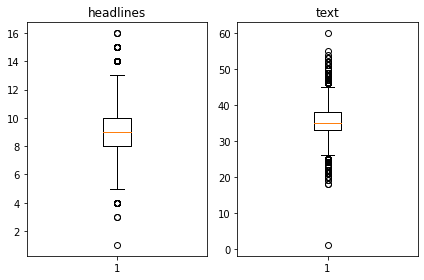

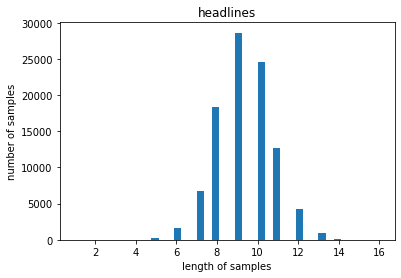

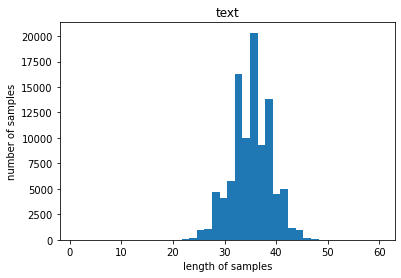

In [18]:
# text와 headlines의 최소, 최대, 평균 길이를 구하고 길이 분포를 시각화

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [50]:
# text와 headlines의 최대길이를 임의로 정합니다.
text_max_len = 40
headlines_max_len = 10

In [51]:
# 임의로 최대길이를 정해줬을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계 확인
# 이를 통해 객관적으로 길이를 결정하는데 도움이 됨
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수 제작

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [52]:
# 이 함수를 이용, text와 headlines에 적용해 우리가 결정한 임의의 길이가 몇 %의 샘플까지 포함하는지 확인
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

# 40과 10로 각각 패딩하면, 해당 길이보다 긴 샘플들은 내용이 잘리게 됨.

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9264699533759282
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8639375755482646


In [53]:
# 정해진 길이보다 길면 제외하는 방법으로 데이터 정제
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 74102


### 시작 토큰과 종료 토큰 추가

In [54]:
# seq2seq 훈련을 위해서 디코더에 시작 토큰과 종료 토큰을 추가
# 시작 토큰은 sostoken, 종료 토큰은 eostoken이라고 지정
# 디코더 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input
# 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target
# 두 개의 문장 모두 headlines 열로부터 만듬

# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [56]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 numpy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련 데이터 테스트 데이터 분리

In [57]:
# 직접 데이터셋을 분리하는 방법을 사용
# 우선 encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만듬

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[30162    44 19711 ... 22141 68174  5263]


In [58]:
# 이 정수 시퀀스를 이용해서 다시 데이터의 샘플 순서를 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [59]:
# 8:2 비율로 훈련 데이터와 테스트 데이터로 분리
# 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기로 지정

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 14820


In [60]:
# 이렇게 정의한 테스트 데이터의 개수를 이용해서 전체 데이터를 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


### 단어집합 만들기 및 정수 인코딩

In [61]:
# 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 변환
# 이를 위해서 각 단어의 고유한 정수를 맵핑하는 작업이 필요. 이과정을 단어 집합을 만든다고 표현
# 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만듬

# keras 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있음
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [62]:
# 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여됨
# 생성죈 단어 집합은 src_tokenizer.word_index에 저장되어 있음.
# 하지만 만든 단어집합에 있는 모든 단어를 사용하지 않고 빈도수가 낮은 단어는 훈련 데이터에서 제외

# 등장 빈도수가 7회 미만인 단어들의 비중을 확인
# src_tokenizer.word_counts.items() 에서 각 단어의 등장 빈도수를 보여줌

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 등장 빈도가 threshold값인 7회 미만인 단어들은 단어 집합에서 70%이상을 차지
# 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.39%
# 그래서 등장 빈도가 7회 미만인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제고

단어 집합(vocabulary)의 크기 : 61724
등장 빈도가 6번 이하인 희귀 단어의 수: 42474
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19250
단어 집합에서 희귀 단어의 비율: 68.81277946989826
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.220416549191691


In [63]:
# 등장 빈도가 7회 미만인 단어를 제외한 단어 집합의 크기가 19250이었는데, 이를 어리잡아 단어 집합의 크기를 19000으로 제한
# num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다.

src_vocab = 19000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 19000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [64]:
# texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행 
# 현재 단어 집합의 크기를 19000으로 제한했으니까 이제 19000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않음

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[490, 886, 119, 2335, 2563, 4905, 35, 1146, 96, 1779, 586, 714, 1410, 233, 1664, 921, 4952, 869, 493, 490, 2093, 1637, 1800, 4905, 1293, 893, 7252, 657, 369, 620, 129, 502, 31, 139, 493, 3189, 7675, 648, 174, 186], [8, 68, 53, 1, 8645, 6990, 5726, 87, 9, 2, 527, 2437, 13151, 15111, 5726, 2940, 34, 68, 4, 527, 995, 209, 8645, 6990, 1563, 3, 3559, 1889, 811, 407, 20, 68, 1], [32, 285, 123, 10646, 2218, 8455, 32, 222, 123, 13694, 542, 193, 1685, 2758, 6071, 98, 276, 1044, 49, 10, 98, 66, 542, 481, 1980, 1024, 93, 175, 292, 756, 7531, 313, 1127, 7532, 5517, 481, 1502, 1024]]


In [65]:
# 더이상 텍스트 데이터가 아니라 정수가 나오고 있다.
# summary에도 동일한 작업
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [66]:
# 고유한 정수가 부여되어있는데, 이는 tar_tokenizer.word_index에 저장되어 있음
# tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장되어 있음
# 이를 통해 통계적 정보를 얻음
# 나온 정보를 활용해서 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼마만큼 비중을 차지하는지 확인

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27293
등장 빈도가 5번 이하인 희귀 단어의 수: 18262
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9031
단어 집합에서 희귀 단어의 비율: 66.9109295423735
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.018981833537319


In [67]:
# 등장 빈도가 5이하인 단어는 약 67%
# 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 6% 밖에 안됨
# 아까와 비슷하게 이 단어들을 모두 제거.
# 어림잡아 9000을 단어 집합의 크기제한으로 설정

tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 576, 1022, 175, 216, 4476, 476, 2404, 3, 7565, 466], [1, 4676, 3690, 4477, 256, 4, 371], [1, 1447, 2734, 499, 24, 92, 6, 1131, 511], [1, 3211, 16, 2223, 4899, 109, 37, 1005, 41, 943], [1, 196, 176, 212, 589, 1916, 341, 16, 48, 3008, 67]]
target
decoder  [[576, 1022, 175, 216, 4476, 476, 2404, 3, 7565, 466, 2], [4676, 3690, 4477, 256, 4, 371, 2], [1447, 2734, 499, 24, 92, 6, 1131, 511, 2], [3211, 16, 2223, 4899, 109, 37, 1005, 41, 943, 2], [196, 176, 212, 589, 1916, 341, 16, 48, 3008, 67, 2]]


전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 9밖에 되지 않았던 headlines 의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요. 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 거예요. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까요.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할 거예요.

In [68]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 59281
훈련 레이블의 개수 : 59281
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### 패딩하기

In [70]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# 모델 설계

In [71]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 디코더 설계

In [72]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [73]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

# 어텐션

In [74]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [75]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

# 모델훈련

In [76]:
# epochs=50하면 시간이 너무 오래 걸려서 5
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=5)

Epoch 1/5
232/232 [==============================] - 157s 628ms/step - loss: 6.6731 - val_loss: 5.8850
Epoch 2/5
232/232 [==============================] - 151s 653ms/step - loss: 5.8441 - val_loss: 5.5364
Epoch 3/5
232/232 [==============================] - 150s 648ms/step - loss: 5.4680 - val_loss: 5.2624
Epoch 4/5
232/232 [==============================] - 151s 651ms/step - loss: 5.1713 - val_loss: 5.0441
Epoch 5/5
232/232 [==============================] - 150s 647ms/step - loss: 4.9168 - val_loss: 4.8929


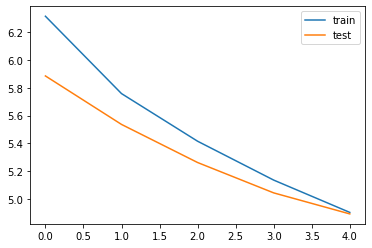

In [77]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 인퍼런스 모델 구현
정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [78]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [79]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [80]:
# 어텐션 메커니즘을 사용하는 출력층을 설계해 주세요.

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [84]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어주세요.

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 모델 테스트
주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어볼게요. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 거예요.

In [85]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [86]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보세요.
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : gujarat congress mlas staying bengaluru resort allowed go mlas karnataka put charge discipline party planned programmes entertainment inside resort include lecture corruption charges upa congress achievements years transparency accountability 
실제 요약 : gujarat congress mlas in bengaluru not allowed to go out 
예측 요약 :  bjp cm mlas to be in gujarat assembly


원문 : least civilians killed air strikes us led coalition iraq syria according coalition report air strikes carried since coalition began operations isis continue hold accountable actions may caused unintentional injury death civilians coalition said 
실제 요약 : us coalition air strikes killed civilians in iraq syria 
예측 요약 :  killed in afghanistan attack in afghanistan


원문 : inter faith couple amarnath got married tree college campus saturday presence family members friends couple said opted get married tree religious bias said wanted start new custom 
실제 요약 : inter faith couple get married in college campus in kerala 
예측 요약 :  ma

# 추출적 요약

In [88]:
from summa.summarizer import summarize

In [87]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data_ex = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [94]:
data_ex.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [100]:
test = data_ex['text']
test[8]

'Andhra Pradesh CM N Chandrababu Naidu has said, "When I met then US President Bill Clinton, I addressed him as Mr Clinton, not as \'sir\'. (PM Narendra) Modi is my junior in politics...I addressed him as sir 10 times." "I did this...to satisfy his ego in the hope that he will do justice to the state," he added.'

In [101]:
# test
summarize(test[8], words=20)

'Andhra Pradesh CM N Chandrababu Naidu has said, "When I met then US President Bill Clinton, I addressed him as Mr Clinton, not as \'sir\'.'

In [102]:
for i in range(10,50):
    print('Summary:')
    print(summarize(test[i], words=20))
    print('Answer:')
    print(data_ex['headlines'][i])

Summary:
Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.
Answer:
UP cousins fed human excreta for friendship with boys
Summary:
Isha Ghosh, an 81-year-old member of Bharat Scouts and Guides (BSG), has been imparting physical and mental training to schoolchildren in Jharkhand for several decades.
Answer:
81-yr-old woman conducts physical training in J'khand schools
Summary:

Answer:
Ram, Krishna didn't smoke, why should we: Ramdev to sadhus at Kumbh
Summary:
Former stripper and regional sales director of a pharmaceutical company, Sunrise Lee, gave a doctor a lap dance in a nightclub to persuade him to prescribe an addictive fentanyl spray in 2012, the company's sales representative told a US court.
Answer:
Pharma exec gave doctor a lap dance to sell medicine in US: Witness
Summary:
"It was a very emotional affair for everyone in my family," said

# 회고

https://github.com/nr-ai/Aiffel_Exploration/blob/master/NewsSummaryBot.ipynb 의 코드를 참고했습니다.

매번 그랬던것 처럼 이 노드를 끝낸것만으로도 나는 행복하다. 사실 결과도 나쁘지 않았다(물론 복붙 수준이지만). 추상적 요약의 결과를 봤을때 요약된 글을 보면서 뭔가 요약이 되어있는것 같기도 하지만 아닌거 같기도 하다. 물론 전처리 과정에서 우리는 많은 부분을 생략을 시켰기에 문장이 매끄럽지 못하다거나, 문맥에 안맞는 부분이 있다던가 하는 문제들은 사실 안고 가야하는거 같다. 이런부분이 아직 기계가 인간처럼 요약을 하기에 한계가 있다는걸 보여주는 증거가 아닐까 싶다. 

추상적 요약은 매우 복잡했다. 사실 잘 읽어 내려가다가 놓쳐서 그냥 의식의 흐름대로 노드를 진행했던거 같다. 보다가 뒷부분 보면 까먹고... 이런건 내 지능의 한계라고 생각한다...복잡한 만큼 정교하게 만들어 진거 같다. 특히나 어텐션을 사용해서 각 나라의 언어에 영향을 받지않고 요약을 해갈수 있다는점은 정말 큰 장점인거 같다. 다만 내가 생각하기에 텐서플로에서 제공하는 autotune처럼 파라미터를 알아서 자동으로 지정해주어서 코드 짜는 사람이 파라미터에 구애받지 않고 잘 작동되었으면 더 좋을거 같다.

솔직히 추상적 요약보다 추출적 요약이 더 매끄럽게 요약된거 같다는 느낌이 든다. 더 간결하고 더 성능좋은 추출적 요약을 더 많이 쓰지 않을까 싶지만, 각자 장단점이 있겠거니 하고 넘어가야 될 거 같다. 일단 완성하는것도 나에게는 버겁기에;